In [504]:
import pandas as pd
from pandas import read_csv 
import numpy as np
import datetime
import csv
from operator import itemgetter
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import collections

In [505]:
dataset=read_csv('soc-sign-bitcoinotc.csv',header=None, names=["source", "target", "rating","time"])

In [506]:
print(dataset.head(5))
print(dataset.shape)

   source  target  rating          time
0       6       2       4  1.289242e+09
1       6       5       2  1.289242e+09
2       1      15       1  1.289243e+09
3       4       3       7  1.289245e+09
4      13      16       8  1.289254e+09
(35592, 4)


In [507]:
# arrtime=[]
# for a in dataset.iloc[:,-1]:
#     arrtime.append(datetime.datetime.fromtimestamp(a))

In [508]:
# dataset.drop('time', inplace=True, axis=1)    
# dataset.insert(3, "time", arrtime, True)
# print(dataset.head(5))

In [509]:
dataset.loc[pd.DataFrame(np.sort(dataset[['source','target']],1),index=dataset.index).drop_duplicates(keep='first').index]
dataset.head(5)

,source,target,rating,time
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09


In [510]:
dataset['time'] = pd.to_datetime(dataset.time * 1e9)
dataset = dataset.set_index('time')
dataset.shape

(35592, 3)

In [511]:
dataset.tail(5)

,source,target,rating
time,,,
2016-01-24 05:14:41.647290112,4499,1810,1
2016-01-24 23:50:28.049489920,2731,3901,5
2016-01-24 23:50:34.034019840,2731,4897,5
2016-01-24 23:53:52.985709824,13,1128,1
2016-01-25 01:12:03.757280000,1128,13,2


In [512]:
# ratings overview by month
dataset.resample('M').rating.value_counts().unstack().sample(5)

rating,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
time,,,,,,,,,,,,,,,,,,,,
2012-08-31,16.0,NaN,NaN,2.0,1.0,4.0,NaN,NaN,4.0,16.0,560.0,145.0,68.0,24.0,36.0,2.0,6.0,9.0,NaN,11.0
2013-08-31,678.0,NaN,1.0,NaN,NaN,6.0,2.0,1.0,1.0,8.0,886.0,163.0,63.0,31.0,33.0,11.0,4.0,5.0,1.0,40.0
2014-07-31,18.0,NaN,NaN,1.0,NaN,4.0,NaN,2.0,3.0,10.0,164.0,56.0,33.0,6.0,16.0,4.0,1.0,NaN,NaN,1.0
2011-09-30,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,180.0,57.0,25.0,8.0,6.0,NaN,NaN,NaN,2.0,2.0
2014-09-30,18.0,1.0,1.0,NaN,NaN,8.0,NaN,2.0,1.0,10.0,110.0,35.0,19.0,11.0,12.0,2.0,1.0,4.0,1.0,2.0


In [513]:
tp1 = dataset.loc['2012']
print(f"Ratings: {len(tp1)}")
tp1.sample(10)

Ratings: 9432


,source,target,rating
time,,,
2012-07-23 18:34:53.260950016,35,1562,3
2012-08-08 09:05:58.049569792,1916,1860,1
2012-11-21 02:10:38.078289920,4,2998,1
2012-09-10 06:29:39.426810112,2017,2288,1
2012-08-01 20:02:27.204140032,2377,2313,10
2012-09-23 17:44:55.609440000,1386,1543,-5
2012-09-12 00:40:00.794669824,2582,2034,1
2012-06-27 04:25:57.500460032,1802,1860,1
2012-11-14 04:15:35.254720000,2929,2388,1


In [514]:
G = nx.Graph()
for i in tp1.index:
  G.add_edge(dataset['source'][i], dataset['target'][i], weight = dataset['rating'][i])

In [515]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 1926\nNumber of edges: 5816\nAverage degree:   6.0395'

In [516]:
# nx.draw(G)  
# plt.draw()
nx.is_connected(G)

False

target
1       59
2        1
4       18
6        9
7       32
        ..
3261     1
3262     1
3263     1
3264     1
3598    20
Name: rating, Length: 1897, dtype: int64
target
1       4.644068
2       8.000000
4       3.444444
6       1.666667
7       2.375000
          ...   
3261    1.000000
3262    1.000000
3263    3.000000
3264    1.000000
3598    1.600000
Name: rating, Length: 1897, dtype: float64


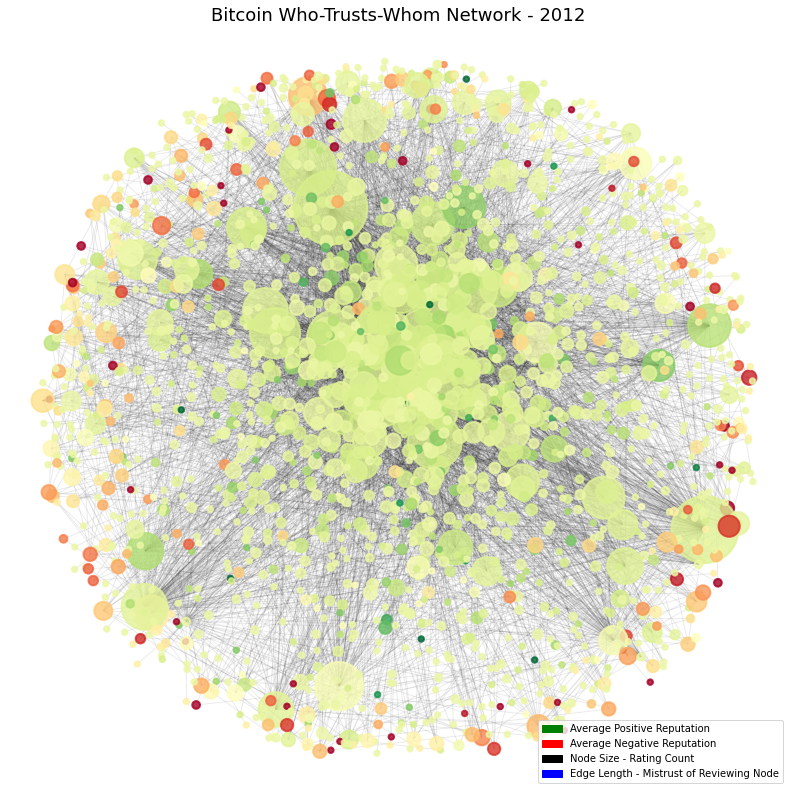

In [517]:
review_counts = tp1.groupby('target').rating.count()
average_reviews = tp1.groupby('target').rating.mean()
print(review_counts)
print(average_reviews)
def get_size(user_id, m=20, min=30):
    s = review_counts.get(user_id)
    if s is not None:
        return min * s
    else:
        return min

def get_color(user_id):
    s = average_reviews.get(user_id)
    if s is None:
        return 0.5
    # need a scaling function to translate -10-10 to 0.0-1.0 for colors maps
    return np.interp(s, (-10, 10), (0, 1))

plt.figure(figsize=(14, 14)) 
plt.title("Bitcoin Who-Trusts-Whom Network - 2012", fontsize=18)

untrusted = mpatches.Patch(color='red', label='Average Negative Reputation')
trusted = mpatches.Patch(color='green', label='Average Positive Reputation')
size = mpatches.Patch(color='black', label='Node Size - Rating Count')
edges = mpatches.Patch(color='blue', label='Edge Length - Mistrust of Reviewing Node')
plt.legend(handles=[trusted, untrusted, size, edges], loc='lower right')

pos = nx.spring_layout(G, k=0.25)
sizes = [get_size(n) for n in G]
colors = [get_color(n) for n in G]

nc = nx.draw_networkx_nodes(
    G, pos, nodelist=G.nodes(), node_size=sizes, linewidths=2.0,
    node_color=colors, cmap=plt.cm.RdYlGn, alpha=0.8
)
ec = nx.draw_networkx_edges(G, pos, arrows=True, alpha=0.08)
ax = plt.axis('off')
plt.show()

[Text(0, 0, '263'),
 Text(0, 0, '233'),
 Text(0, 0, '212'),
 Text(0, 0, '141'),
 Text(0, 0, '123'),
 Text(0, 0, '115'),
 Text(0, 0, '114'),
 Text(0, 0, '105'),
 Text(0, 0, '102'),
 Text(0, 0, '98'),
 Text(0, 0, '88'),
 Text(0, 0, '85'),
 Text(0, 0, '84'),
 Text(0, 0, '82'),
 Text(0, 0, '81'),
 Text(0, 0, '80'),
 Text(0, 0, '74'),
 Text(0, 0, '72'),
 Text(0, 0, '70'),
 Text(0, 0, '69'),
 Text(0, 0, '67'),
 Text(0, 0, '65'),
 Text(0, 0, '64'),
 Text(0, 0, '58'),
 Text(0, 0, '56'),
 Text(0, 0, '55'),
 Text(0, 0, '54'),
 Text(0, 0, '48'),
 Text(0, 0, '47'),
 Text(0, 0, '44'),
 Text(0, 0, '43'),
 Text(0, 0, '42'),
 Text(0, 0, '41'),
 Text(0, 0, '40'),
 Text(0, 0, '39'),
 Text(0, 0, '35'),
 Text(0, 0, '34'),
 Text(0, 0, '33'),
 Text(0, 0, '31'),
 Text(0, 0, '30'),
 Text(0, 0, '29'),
 Text(0, 0, '28'),
 Text(0, 0, '27'),
 Text(0, 0, '26'),
 Text(0, 0, '25'),
 Text(0, 0, '24'),
 Text(0, 0, '23'),
 Text(0, 0, '22'),
 Text(0, 0, '21'),
 Text(0, 0, '20'),
 Text(0, 0, '19'),
 Text(0, 0, '18'),
 Te

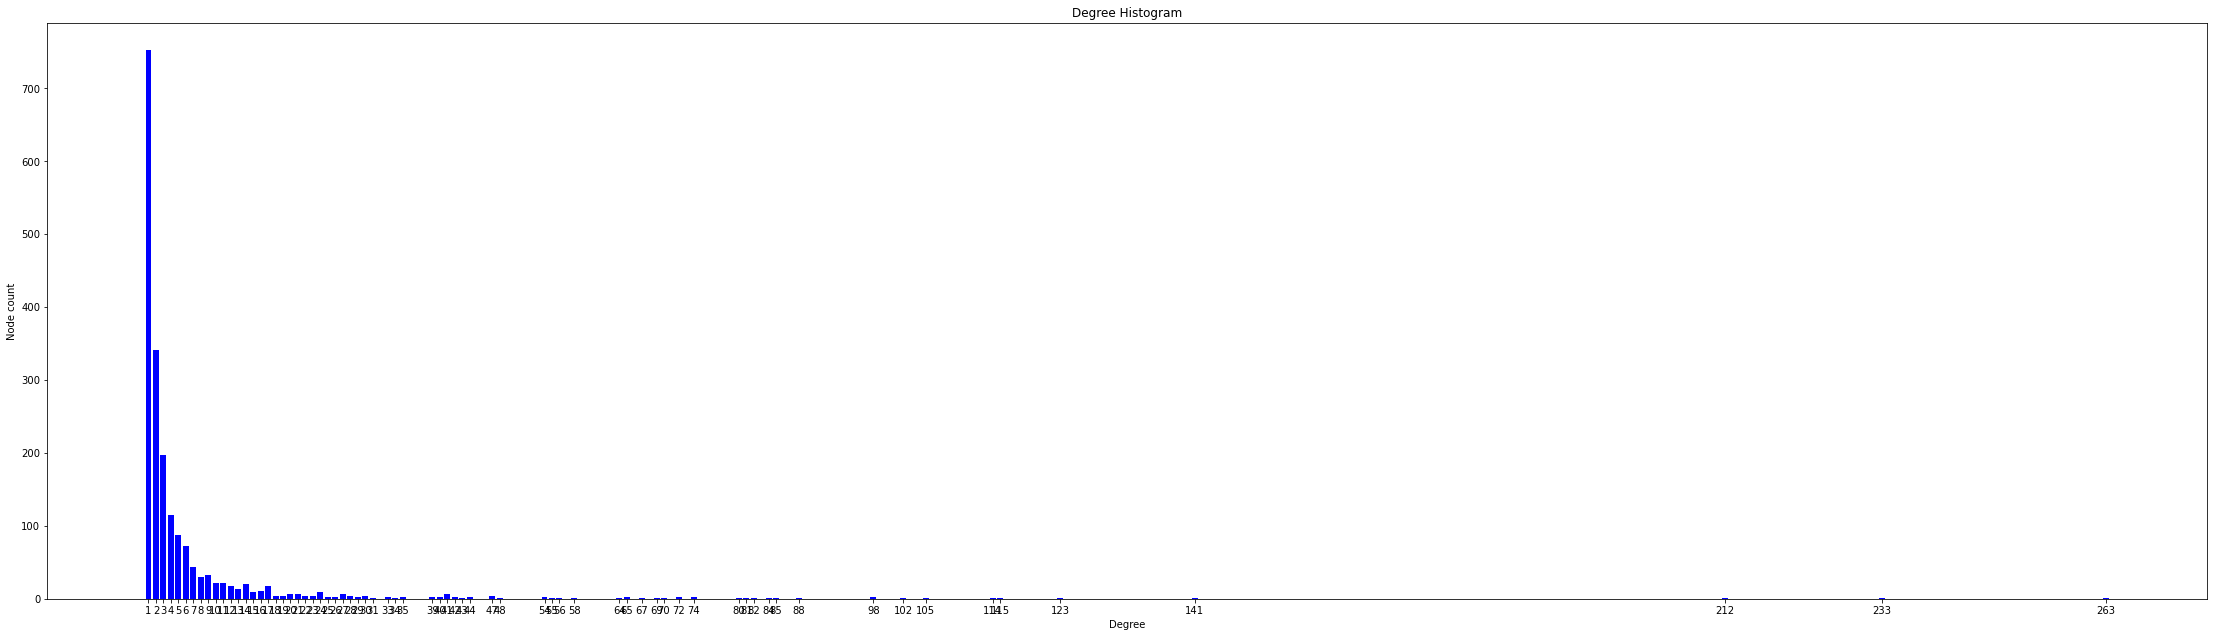

In [518]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
fig, ax = plt.subplots()
#plt.figure(figsize = (200, 100))
plt.subplots_adjust(left=0, right=5, bottom=0, top=2)
plt.bar(deg, cnt, width=0.8, color="b")
plt.title("Degree Histogram")
plt.ylabel("Node count")
plt.xlabel("Degree")
ax.set_xticks([d for d in deg])
ax.set_xticklabels(deg)

In [ ]:
l = []
for i in dataset.index:
    if(dataset['rating'][i]<0):
        l.append(dataset['source'][i])
#print(l)  

x = nx.closeness_centrality(G)
import operator
sorted_x = sorted(x.items(), key=operator.itemgetter(1))
common=[]
closeness=[]
for i in sorted_x[-20:]:
    closeness.append(i[0])
#print(closeness)    
for k in closeness:
    for j in l:      
        if k==j:
            common.append(j)          
print("closeness - fraudulent nodes :" , np.unique(common))      

y = nx.degree_centrality(G)
import operator
sorted_y = sorted(y.items(), key=operator.itemgetter(1))
common=[]
closeness=[]
for i in sorted_y[-20:]:
    closeness.append(i[0])
for k in closeness:
    for j in l:      
        if k==j:
            common.append(j)          
print("degree - fraudulent nodes :" , np.unique(common)) 

z = nx.betweenness_centrality(G)
import operator
sorted_z = sorted(z.items(), key=operator.itemgetter(1))
common=[]
closeness=[]
for i in sorted_z[-20:]:
    closeness.append(i[0])
for k in closeness:
    for j in l:      
        if k==j:
            common.append(j)          
print("betweeness - fraudulent nodes :" , np.unique(common)) 

a = nx.pagerank(G,max_iter=10000)
import operator
sorted_a = sorted(a.items(), key=operator.itemgetter(1))
common=[]
closeness=[]
for i in sorted_a[-20:]:
    closeness.append(i[0])
for k in closeness:
    for j in l:      
        if k==j:
            common.append(j)          
print("pagerank - fraudulent nodes :" , np.unique(common)) 


closeness - fraudulent nodes : [   1   35  304  546  905 1201 1334 1386 1396 1543 1810 1832 1899 1953
 2028 2125 2173 2296]
degree - fraudulent nodes : [   1   13   35  304  905 1317 1386 1396 1744 1771 1810 1899 1953 2028
 2067 2125 2266 2296 2642]
betweeness - fraudulent nodes : [  13   35  304  905 1281 1317 1386 1396 1615 1771 1810 1899 1953 2028
 2067 2125 2266 2296 2642 2877]


c:\users\brsan\appdata\local\programs\python\python38-32\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:154: RuntimeWarning: overflow encountered in double_scalars
  err = sum([abs(x[n] - xlast[n]) for n in x])
c:\users\brsan\appdata\local\programs\python\python38-32\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:151: RuntimeWarning: overflow encountered in double_scalars
  x[nbr] += alpha * xlast[n] * W[n][nbr][weight]
c:\users\brsan\appdata\local\programs\python\python38-32\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:151: RuntimeWarning: invalid value encountered in double_scalars
  x[nbr] += alpha * xlast[n] * W[n][nbr][weight]
c:\users\brsan\appdata\local\programs\python\python38-32\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:154: RuntimeWarning: invalid value encountered in double_scalars
  err = sum([abs(x[n] - xlast[n]) for n in x])
c:\users\brsan\appdata\local\programs\python\python38-32\l

In [ ]:
# y = nx.degree_centrality(G)
# import operator
# sorted_y = sorted(y.items(), key=operator.itemgetter(1))
# print(sorted_y[-20:])

In [ ]:
# z = nx.betweenness_centrality(G)
# import operator
# sorted_z = sorted(z.items(), key=operator.itemgetter(1))
# print(sorted_z[-20:])

In [ ]:
# a = nx.pagerank(G,max_iter=10000)
# import operator
# sorted_a = sorted(a.items(), key=operator.itemgetter(1))
# print(sorted_a[-20:])

In [ ]:
# l = []
# for i in dataset.index:
#     if(dataset['rating'][i]<0):
#         l.append(dataset['source'][i])
# print(l)        


In [ ]:
# common=[]
# for i in sorted_x[-20:]:
#     for j in l:
#         if i==j:
#             common.append(j)
# print(common)            